In [42]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import sys

import xml.etree.ElementTree as ET
import pyvista as pv

import vtuIO
from ogs6py.ogs import OGS

In [43]:
out_dir = Path("output")
if not out_dir.exists():
    out_dir.mkdir(parents=True)

ogs_path = "/home/wenqing/Code/build/ogs6_release/bin"

In [44]:
def get_vtu_name(pvd_file_name, vtu_id = 0, out_dir = out_dir):
    tree = ET.parse(pvd_file_name)
    root = tree.getroot()
    # Get the last DataSet tag if t == 0
    # else get DataSet at timestep = time

    try:
        dataset = root.findall(".//DataSet")[-1] if vtu_id == 0\
                  else root.findall(".//DataSet")[vtu_id]

        if dataset == None:
            raise NameError(f'The pvd file {pvd_file_name} does not contain'
                               f' a vtu file at time {time}.')
        # Get the 'file' attribute of the last DataSet tag
        file_attribute = dataset.attrib["file"]
        return os.path.join(out_dir, file_attribute);
    except Exception as e:
        print(f"An error occurred: {e}")


In [45]:
class Triangulation:
    """Manage the triangulation data for contour plot"""
    def __init__(self, vtu_file_name, component_0_id = 0, component_1_id = 1):
        self.m_plot = vtuIO.VTUIO(vtu_file_name, dim=2)
        self.triang = tri.Triangulation(self.m_plot.points[:, component_0_id],
                                   self.m_plot.points[:, component_1_id])

    def get_contour_data(self, fig, variable_name, component_id = 0,
                         scale = 1.0, cmap = "jet"):
        data = self.m_plot.get_point_field(variable_name)
        if data.ndim == 1:
            return fig.tricontourf(self.triang, data * scale,
                                   cmap = cmap)
        try:
            if component_id >= data.ndim:
                raise NameError(f'Component id {component_id} is not smaller'
                               f' than the data {variable_name} component number.')
            return fig.tricontourf(self.triang, data[:, component_id] * scale,
                                   cmap = cmap)
        except Exception as e:
            print(f"An error occurred: {e}")
    
    def get_contour_data_trace(self, fig, variable_name,
                         scale = 1.0, cmap = "jet"):
        data = self.m_plot.get_point_field(variable_name)
        try:
            if data.ndim < 3:
                raise NameError(f'The variable {variable_name} is not a tensor.')
            return fig.tricontourf(self.triang, (data[:, 0] + data[:, 1]
                                                 + data[:, 2]) * scale/3.0,
                                   cmap = cmap)
        except Exception as e:
            print(f"An error occurred: {e}")

def contour_plot(vtu_file_name, title):
    m_plot = vtuIO.VTUIO(vtu_file_name, dim=2)
    triang = tri.Triangulation(m_plot.points[:, 0], m_plot.points[:, 1])
    triang = tri.Triangulation(m_plot.points[:, 0], m_plot.points[:, 1])
    eps_plot = m_plot.get_point_field("epsilon")
    sigma_plot = m_plot.get_point_field("sigma") * 1.e-6
    u_plot = m_plot.get_point_field("displacement") * 1.0e+3

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
    ax[0, 0].set_title(title, loc="left", y=1.12)
    plt.subplots_adjust(wspace=0.5)

 
    contour_ux = ax[0, 0].tricontourf(triang, u_plot[:, 0], cmap="gist_rainbow")
    contour_uy = ax[0, 1].tricontourf(triang, u_plot[:, 1], cmap="gist_rainbow")
    fig.colorbar(contour_ux, ax=ax[0, 0], label="Displacement / mm")
    fig.colorbar(contour_uy, ax=ax[0, 1], label="Displacement / mm")

    contour_eps_1 = ax[1, 0].tricontourf(triang, eps_plot[:, 0], cmap="viridis")
    fig.colorbar(contour_uy, ax=ax[1, 0], label="Horizontal strain [--]")

    contour_sigma_1 = ax[1, 1].tricontourf(triang, sigma_plot[:, 0], cmap="viridis")
    fig.colorbar(contour_sigma_1, ax=ax[1, 1], label="Horizontal stress / MPa")

    fig.tight_layout()
    plt.savefig(vtu_file_name + ".png")
    plt.show()

In [46]:
def plot_temporal_variation(pvd_file_name, variable_name, label, points,
                            t_max=850, interpolation_method="nearest"):
    pvdfile = vtuIO.PVDIO(pvd_file_name, dim=2)
    times = pvdfile.timesteps
    data = pvdfile.read_time_series(variable_name, points, interpolation_method="nearest")
    colors = ['b-', 'k-']
    point_keys = list(points.keys())

    plt.rcParams["figure.figsize"] = [4, 4]
    for i, key in enumerate(point_keys):
        plt.plot(times, data[key], colors[i], label = key)

    plt.legend()
    plt.xlabel("Time [s]")
    plt.xlim(0., t_max)
    plt.ylabel(label)

In [47]:
class SingleOGSModel:
    """An OGS run model"""

    def __init__(self, project_file, output_prefix, out_dir = out_dir):

        self.model = OGS(INPUT_FILE = project_file,
                         PROJECT_FILE =f"{out_dir}/modified.prj")

        self.model.replace_text(output_prefix, xpath="./time_loop/output/prefix")

        self.out_dir = out_dir
        self.output_prefix = output_prefix

    def run(self, mesh_path):
        self.model.write_input()

        if ogs_path != "":
            self.model.run_model(
                logfile = os.path.join(self.out_dir, 'out.txt'),
                path=ogs_path,
                args=f"-o {self.out_dir} -m {mesh_path}",
            )
        else:
            self.model.run_model(
                logfile = os.path.join(self.out_dir, 'out.txt'),\
                args=f"-o {self.out_dir} -m {mesh_path}"
            )

    def get_pvd_name(self):
        return os.path.join(self.out_dir,  self.output_prefix + '.pvd')

    def get_vtu_name(self, vtu_id = 0):
        return get_vtu_name(self.get_pvd_name(), vtu_id, out_dir = self.out_dir)

In [48]:
taskB = SingleOGSModel(project_file = 'TaskB.prj',
                       output_prefix = 'taskB') 

In [49]:
taskB.run(mesh_path='.')

OGS finished with project file output/modified.prj.
Execution took 439.9636552333832 s


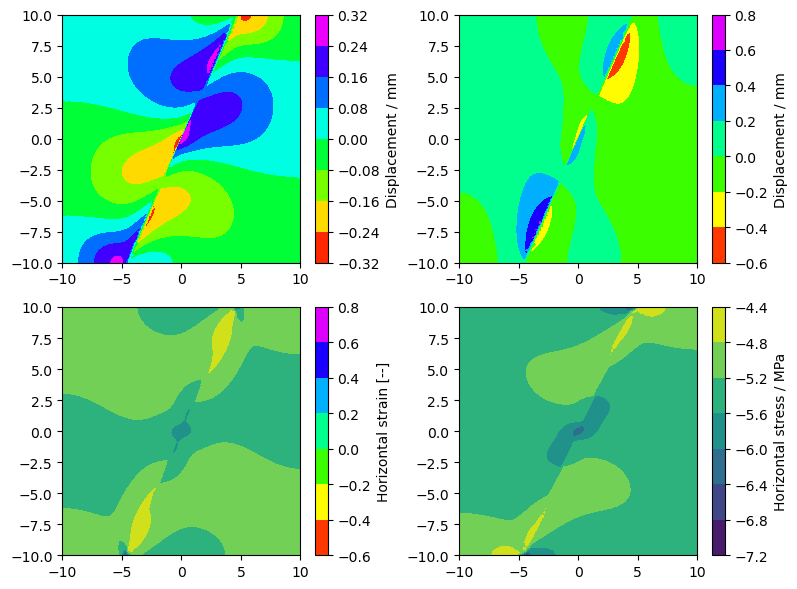

In [50]:
contour_plot(taskB.get_vtu_name(), '')

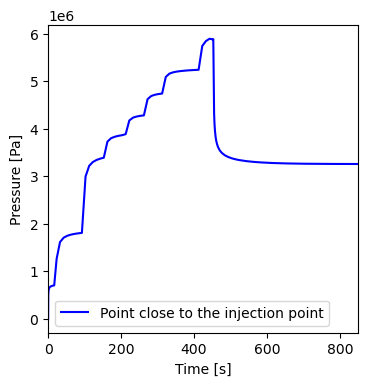

In [51]:
points = {'Point close to the injection point': (-0.210163, -0.453686, 0.0),}
plot_temporal_variation(pvd_file_name = taskB.get_pvd_name(),
                        variable_name = 'pressure_interpolated',
                        label = 'Pressure [Pa]',
                        points = points)

## Variable profile in fracture at the time end

/tmp/ipykernel_3270/1479838653.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return mesh.extract_cells(np.where(matIDs == material_id)[0])
/tmp/ipykernel_3270/1479838653.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  xs = np.linalg.norm(sampled_line.points - start_point, axis=1)


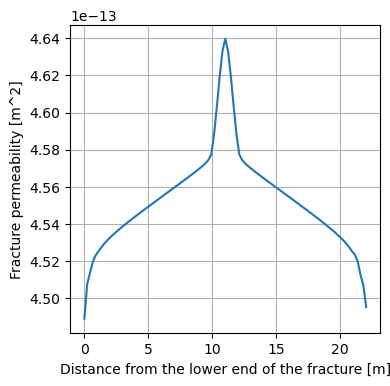

In [52]:
def get_sub_mesh_by_material_id(mesh, material_id):
    matIDs = mesh.cell_data["MaterialIDs"]
    return mesh.extract_cells(np.where(matIDs == material_id)[0])

mesh = pv.read( taskB.get_vtu_name())
fracture_mesh = get_sub_mesh_by_material_id(mesh, 1)
start_point = np.array([-4.63235, -10, 0]) 
end_point = np.array([4.63235, 10, 0])
line = pv.Line(start_point, end_point, resolution=100)
sampled_line = fracture_mesh.sample_over_line(start_point, end_point, resolution=100)
xs = np.linalg.norm(sampled_line.points - start_point, axis=1)
k_f = sampled_line['fracture_permeability']
plt.plot(xs, k_f)
plt.xlabel("Distance from the lower end of the fracture [m]")
plt.ylabel("Fracture permeability [m^2]")
plt.grid(True)
plt.show()


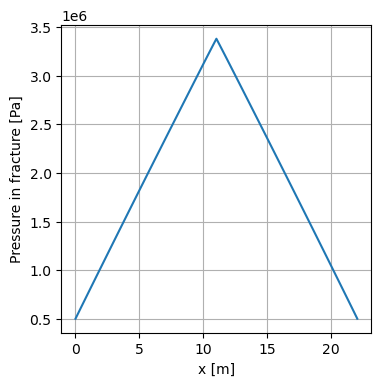

In [53]:
k_f = sampled_line['pressure_interpolated']
plt.plot(xs, k_f)
plt.xlabel("x [m]")
plt.ylabel("Pressure in fracture [Pa]")
plt.grid(True)
plt.show()